## Extra credit assignment

In this homework, you will use two data sets: NYC restaurant inspections and 311 complaints. NYC DOHMH conducts inspections for all restaurants in the city on regular basis and report or take suitable action against the concerned restaurant. You'll use features from the restaurant violations and will check how well these are to predict the 311 complaint types regarding restaurants. You will also use clustering to check which areas are similar in terms of restaurant violations. 

In [1]:
import pandas as pd
import numpy as np
import os
import requests
import zipfile
from datetime import datetime
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial.distance import cdist, pdist
import statsmodels.formula.api as smf
import urllib
import matplotlib.cm as cm
from sklearn import metrics
from sklearn import preprocessing
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=Warning)
%matplotlib inline

### Download restaurant inspections data

other method is to manually download from the website: https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j

In [2]:
## read the data

data = pd.read_csv('/home/jovyan/shared/Data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv', parse_dates=['INSPECTION DATE'])
data.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,RECORD DATE,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,50100205,FOUR FOUR SOUTH VILLAGE TAIPEI BEEF NOODLES,Queens,3806,PRINCE ST,11354.0,7183137588,Chinese,2019-11-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.760066,-73.832570,407.0,20.0,87100.0,4439964.0,4.049720e+09,QN22
1,41434246,SILVER KITCHEN,Queens,4301,21 STREET,11101.0,7184331327,American,2018-08-15,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.750557,-73.945718,402.0,26.0,1900.0,4005198.0,4.004410e+09,QN31
2,41139783,JK & SONS COFFEE SHOP,Brooklyn,801,BROADWAY,11206.0,7187822366,American,2018-09-25,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Re-inspection,40.699713,-73.940137,304.0,34.0,38900.0,3071691.0,3.031320e+09,BK78
3,40394762,CAROLINE'S ON BROADWAY,Manhattan,750,7 AVENUE,10019.0,2127574100,American,2017-10-18,Violations were cited in the following area(s).,...,11/30/2021,Cycle Inspection / Initial Inspection,40.760746,-73.983525,105.0,4.0,12500.0,1024795.0,1.010210e+09,MN17
4,50102980,THE HOLY GROUP,Queens,10402,NORTHERN BLVD,11368.0,9176226465,Other,2021-09-14,Violations were cited in the following area(s).,...,11/30/2021,Pre-permit (Operational) / Initial Inspection,40.757684,-73.864471,403.0,21.0,37900.0,4042649.0,4.017190e+09,QN26


In [3]:
data.columns

Index(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE DESCRIPTION', 'INSPECTION DATE', 'ACTION', 'VIOLATION CODE',
       'VIOLATION DESCRIPTION', 'CRITICAL FLAG', 'SCORE', 'GRADE',
       'GRADE DATE', 'RECORD DATE', 'INSPECTION TYPE', 'Latitude', 'Longitude',
       'Community Board', 'Council District', 'Census Tract', 'BIN', 'BBL',
       'NTA'],
      dtype='object')

You only need certain columns for the tasks, namely 'CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude'

'CAMIS' is a unique identifier for a restaurant/business. 'INSPECTION DATE' is the date on which inspection took place. 'ACTION' tells what kind of action was taken, 'VIOLATION DESCRIPTION' is the type of violation reported.

'SCORE' is the measure of severity of violations reported. A higher score means the restaurant had more violations/bad violations. 

'GRADE' is also a measure of restaurant violations. The best grade is 'A' (which means restaurant had minor/no violations), followed by 'B' and 'C', which mean more serious violations. 'P' grade means the inspection is pending and 'N' and 'Z' mean grades was not assigned due to some reasons.

In [4]:
## keep only the above columns
data = data[['CAMIS', 'ZIPCODE', 'INSPECTION DATE', 'ACTION', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'Latitude', 'Longitude']]

In [5]:
data.shape

(383171, 9)

### Keep data only for 2019

In [6]:
data = data[data['INSPECTION DATE'].dt.year == 2019]

In [7]:
len(data)

145583

### Remove rows where the 'ACTION' was restaurant closure: 'Establishment Closed by DOHMH.  Violations were cited in the following area(s) and those requiring immediate action were addressed.' and 'Establishment re-closed by DOHMH'

In [8]:
data = data[(data['ACTION']!= 'Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.') & (data['ACTION']!= 'Establishment re-closed by DOHMH')]


In [9]:
len(data)

139693

### You only need certain type of violations for further analysis. Keep only the rows where 'VIOLATION DESCRIPTION' was one of the below categories

In [10]:
violCat = pd.read_csv('RestViol_types.csv')
violCat.head()

,VIOLATION DESCRIPTION,count
0,Facility not vermin proof. Harborage or condit...,41352
1,Evidence of mice or live mice present in facil...,27816
2,"Food contact surface not properly washed, rins...",25889
3,Food not protected from potential source of co...,25336
4,Cold food item held above 41Âº F (smoked fish ...,22834


In [11]:
# keep rows just for above categories

data = data[data['VIOLATION DESCRIPTION'].isin(violCat['VIOLATION DESCRIPTION'])]
data.shape

(62738, 9)

### Filter out GRADES that are 'P', 'N' and 'Z'

Do not remove the NaN values from 'GRADE' yet

In [7]:
data.GRADE.unique()

array(['C', 'B', 'A', nan, 'N', 'Z', 'P'], dtype=object)

In [13]:
data = data[(data['GRADE'] != 'P') & (data['GRADE'] != 'N') & (data['GRADE'] != 'Z')]

In [14]:
len(data)

61987

Zip codes shapefile

In [12]:
# !git clone https://github.com/CUSP2020PUI/Data.git

# zips = gpd.read_file("Data/zip_code/ZIP_CODE_040114.shp")
# zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
# zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
# zips.head()

In [16]:
# or use this
urllib.request.urlretrieve ("https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip", 
                            "ZIPS.zip")
with zipfile.ZipFile('ZIPS.zip', 'r') as zip_ref:
    zip_ref.extractall('ZIPS/')
    
zips = gpd.read_file("ZIPS/ZIP_CODE_040114.shp")
zips = zips[['ZIPCODE', 'POPULATION', 'geometry']]
zips['ZIPCODE'] = zips['ZIPCODE'].astype(int)
zips.head()

,ZIPCODE,POPULATION,geometry
0,11436,18681.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,62426.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,83866.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,56527.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,72280.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."


In [17]:
len(zips)

263

### Merge the violations data with zip code shapefile on column 'ZIPCODE'

In [18]:
merge_df = pd.merge(data,zips.drop_duplicates('ZIPCODE'), on='ZIPCODE',how = 'inner')

In [19]:
len(merge_df)

61172

In [20]:
merge_df.head(2)

,CAMIS,ZIPCODE,INSPECTION DATE,ACTION,VIOLATION DESCRIPTION,SCORE,GRADE,Latitude,Longitude,POPULATION,geometry
0,50093646,11366.0,2019-08-07,Violations were cited in the following area(s).,Proper sanitization not provided for utensil w...,11.0,A,40.729259,-73.780988,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."
1,50035638,11366.0,2019-04-29,Violations were cited in the following area(s).,"Food contact surface not properly washed, rins...",22.0,NaN,40.725867,-73.791429,13168.0,"POLYGON ((1047964.522 205966.960, 1047895.063 ..."


### Next, you need to aggregare features by zipcode. You need to get number of violations, average score, and ratio of each grade 'A', 'B' and 'C'. The ratio for a particular grade 'A' should be calculated as number of inspections when restaurants were graded 'A' divided by total number of inspections. In the end, you should have 5 above featues for each zip code.

In [21]:
# get number of violations and average score
## merge number of violations, avg score and grade ratios 
## get each grade ratio per zip code
# agg_zip_df = merge_df.groupby('ZIPCODE').agg({'VIOLATION DESCRIPTION':['count'],'SCORE':['mean'],'GRADE':['count']})
# agg_zip_df.head()
merge_df['GRADE'] = merge_df['GRADE'].fillna('NaN')
violation_count_grade_df = merge_df.groupby(['ZIPCODE','GRADE'])['VIOLATION DESCRIPTION'].count().reset_index().rename(columns={'VIOLATION DESCRIPTION':'grade_type_violation_count'})
average_score_grade_df = merge_df.groupby(['ZIPCODE'])['SCORE'].mean().reset_index().rename(columns={'SCORE':'avg_score'})
violation_count_tot_df = merge_df.groupby(['ZIPCODE'])['VIOLATION DESCRIPTION'].count().reset_index().rename(columns={'VIOLATION DESCRIPTION':'total_violation_count'})
agg_zip_df = pd.merge(violation_count_tot_df, average_score_grade_df, on='ZIPCODE')
agg_zip_df = pd.merge(agg_zip_df, violation_count_grade_df, on='ZIPCODE')
agg_zip_df['grade_type_violation_count'] = agg_zip_df['grade_type_violation_count']/agg_zip_df['total_violation_count']

agg_zip_df = agg_zip_df[agg_zip_df['GRADE']!='NaN']
agg_zip_df = pd.pivot_table(agg_zip_df, columns='GRADE', values='grade_type_violation_count', index=['ZIPCODE','total_violation_count','avg_score']).reset_index().fillna(0)
agg_zip_df

GRADE,ZIPCODE,total_violation_count,avg_score,A,B,C
0,10001.0,1087,19.870285,0.435143,0.066237,0.016559
1,10002.0,1512,21.900662,0.341270,0.095238,0.029101
2,10003.0,1650,19.778047,0.391515,0.089091,0.024242
3,10004.0,323,22.167702,0.402477,0.046440,0.055728
4,10005.0,114,18.535088,0.500000,0.052632,0.026316
...,...,...,...,...,...,...
201,11691.0,87,20.218391,0.494253,0.080460,0.000000
202,11692.0,16,14.062500,0.750000,0.000000,0.000000
203,11693.0,65,18.384615,0.507692,0.046154,0.000000
204,11694.0,52,14.826923,0.673077,0.000000,0.000000


### Read 311 data.

This data containts all restaurant related complaints for 2019. 'Unique Key' is a unique identifier for each complaint

In [22]:
data311 = pd.read_csv('311_foodComplaints.csv')
data311.head()

,Unique Key,Incident Zip,Complaint Type,Descriptor
0,34057077,10020.0,Food Establishment,Dishwashing/Utensils
1,34057113,11104.0,Food Poisoning,1 or 2
2,34057299,10027.0,Food Establishment,Rodents/Insects/Garbage
3,34057325,10017.0,Food Establishment,Bare Hands in Contact w/ Food
4,34057330,11385.0,Food Establishment,Bare Hands in Contact w/ Food


In [23]:
data311.shape

(22388, 4)

In [24]:
data311 = data311.rename(columns={"Incident Zip": "ZIPCODE"})

### Group these 311 complaints by zip code

In [25]:
group311_df = data311.groupby(['ZIPCODE'])['Unique Key'].count().reset_index()
group311_df = group311_df.rename(columns={"Unique Key": "Number_of_Complaints"})

In [26]:
## merge with zips shapefile and normalize 311 complaints by population (per 1000 people)
merge311_df = pd.merge(group311_df,zips.drop_duplicates('ZIPCODE'), on='ZIPCODE',how = 'inner')
merge311_df['pop_1000']= merge311_df['POPULATION']/1000
merge311_df['normalized_complaints']= merge311_df['Number_of_Complaints']/merge311_df['pop_1000']

In [27]:
## merge with the violations features data from above

merge_all_df = pd.merge(merge311_df, agg_zip_df, on='ZIPCODE',how = 'inner')

In [28]:
merge_all_df.head(2)

,ZIPCODE,Number_of_Complaints,POPULATION,geometry,pop_1000,normalized_complaints,total_violation_count,avg_score,A,B,C
0,10001.0,331,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",22.413,14.768215,1087,19.870285,0.435143,0.066237,0.016559
1,10002.0,348,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",81.305,4.280180,1512,21.900662,0.341270,0.095238,0.029101


### Normalize the number of 311 complaints and number of violations by population (per 1000 people)

In [29]:
merge_all_df['normalized_violations']= merge_all_df['total_violation_count']/merge_all_df['pop_1000']

In [30]:
# check statistics of all features
merge_all_df.describe()

,ZIPCODE,Number_of_Complaints,POPULATION,pop_1000,normalized_complaints,total_violation_count,avg_score,A,B,C,normalized_violations
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,10761.283582,110.925373,40648.497512,40.648498,inf,304.268657,19.183920,0.452839,0.067590,0.028462,inf
std,581.276220,100.775192,28378.111363,28.378111,NaN,314.512365,3.428143,0.148355,0.050480,0.033991,NaN
min,10001.000000,1.000000,0.000000,0.000000,0.170940,1.000000,6.500000,0.000000,0.000000,0.000000,0.512821
25%,10121.000000,33.000000,18818.000000,18.818000,1.478852,78.000000,18.191083,0.381443,0.037037,0.000000,3.431100
50%,11004.000000,88.000000,38116.000000,38.116000,2.438132,200.000000,19.587342,0.417722,0.067961,0.023810,5.748858
75%,11356.000000,153.000000,60267.000000,60.267000,4.203822,395.000000,21.259446,0.470588,0.087719,0.039216,12.659628
max,11697.000000,505.000000,109069.000000,109.069000,inf,1650.000000,30.500000,1.000000,0.333333,0.285714,inf


In [31]:
## keep only rows where normalized 311 complaints (per 1000 people) are <30
merge_all_df = merge_all_df[merge_all_df['normalized_complaints'] < 30]

In [32]:
merge_all_df.head(2)

,ZIPCODE,Number_of_Complaints,POPULATION,geometry,pop_1000,normalized_complaints,total_violation_count,avg_score,A,B,C,normalized_violations
0,10001.0,331,22413.0,"POLYGON ((981958.647 213464.453, 981980.328 21...",22.413,14.768215,1087,19.870285,0.435143,0.066237,0.016559,48.498639
1,10002.0,348,81305.0,"POLYGON ((991339.870 207576.784, 991330.490 20...",81.305,4.280180,1512,21.900662,0.341270,0.095238,0.029101,18.596642


In [33]:
#make it geopandas dataframe to visualize on map
merge_all_df_gpd = gpd.GeoDataFrame(merge_all_df)

### Visualization

Plot normalized number of violations, average score and normalized 311 complaints on separate maps 

<AxesSubplot:>

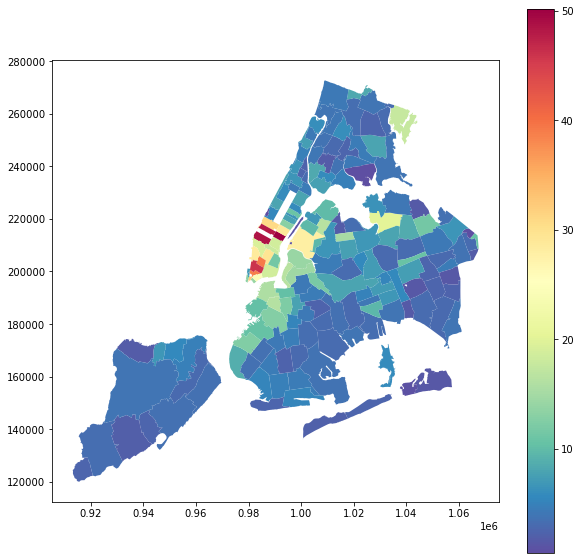

In [34]:
## normalized number of violations (per 1000 people)
merge_all_df_gpd.plot(column='normalized_violations',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

<AxesSubplot:>

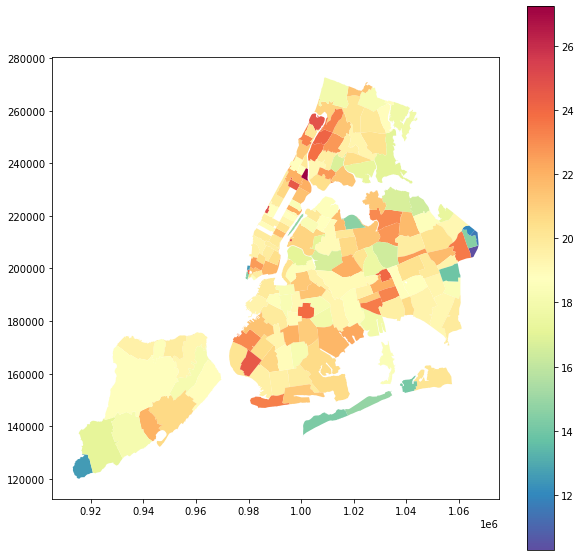

In [35]:
## average score
merge_all_df_gpd.plot(column='avg_score',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

<AxesSubplot:>

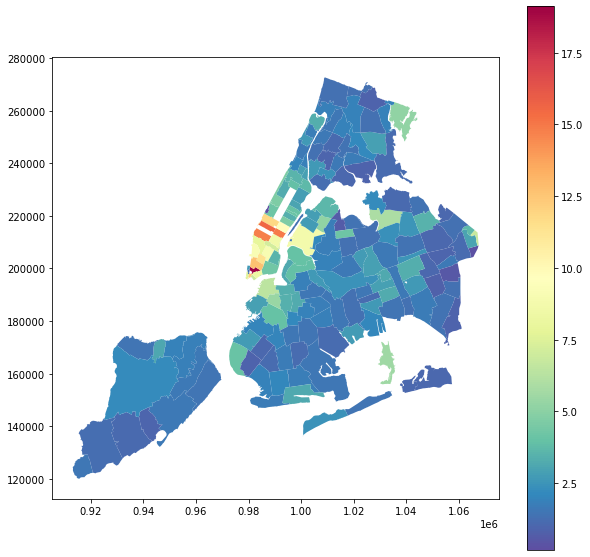

In [36]:
## normalized 311 complaints (per 1000 people)

merge_all_df_gpd.plot(column='normalized_complaints',colormap='Spectral_r',legend=True,markersize=0.01,figsize=(10,10),missing_kwds={
                "color": "lightgrey", ## what to do with missing values
                "edgecolor": "red",
                "hatch": "///",
                "label": "Missing values",
                },)

### Perform clustering analyses by assigning each zipcode to a cluster. Use K-means clustering and choose appropriate number of clusters with average silhouette score and visualize the clusters on the map.

Take only the following features: normalized number of violations, average score and ratios for each grade for the task

These features make an approximate profile of a neighborhood in terms of the quality and performance of restaurants and food businesses present there. With clustering, we would get an idea about what areas have similar profiles and would help understand the areas where restaurants behave similarly. 

Make sure to standardize the data before clustering

In [37]:
## perform clustring analyses
## use average silhouette score (just report the scores and choose best for number of clusters to be used)
## try with (3-15 clusters)


In [38]:
selected_df = merge_all_df[['ZIPCODE','normalized_violations','avg_score','A','B','C']]
selected_df= selected_df.set_index('ZIPCODE')
selected_mean = selected_df.mean().to_dict()
selected_std = selected_df.std().to_dict()

In [39]:
for col in selected_df.columns:
    selected_df[col] = (selected_df[col] - selected_mean[col])/selected_std[col]

In [40]:
selected_df.head()

,normalized_violations,avg_score,A,B,C
ZIPCODE,,,,,
10001.0,4.366083,0.049474,0.134235,-0.169548,-0.419605
10002.0,1.118381,0.818585,-0.825497,0.428622,-0.057242
10003.0,2.305720,0.014534,-0.311801,0.301830,-0.197611
10005.0,0.625858,-0.456301,0.797322,-0.450181,-0.137704
10006.0,2.597515,0.192334,-0.414773,-0.472564,0.293431


In [41]:
for n_clusters in range(3, 15): #try different numbers of clusters
    km = KMeans(n_clusters=n_clusters, random_state=99)
    cluster_labels = km.fit_predict(selected_df)
    #report average Silhouette score
    silhouette_avg = silhouette_score(selected_df, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))

For n_clusters =3, the average silhouette_score is :0.31576568975207475
For n_clusters =4, the average silhouette_score is :0.3605977339331824
For n_clusters =5, the average silhouette_score is :0.3644171654563263
For n_clusters =6, the average silhouette_score is :0.3307396981951205
For n_clusters =7, the average silhouette_score is :0.238574365413165
For n_clusters =8, the average silhouette_score is :0.2385741209775579
For n_clusters =9, the average silhouette_score is :0.22833691436277875
For n_clusters =10, the average silhouette_score is :0.24904355593700758
For n_clusters =11, the average silhouette_score is :0.24160291209615212
For n_clusters =12, the average silhouette_score is :0.23815085183199294
For n_clusters =13, the average silhouette_score is :0.248280466095079
For n_clusters =14, the average silhouette_score is :0.25377091613060526


***For n_clusters =5, the average silhouette_score is :0.3644171654563263 , is the highest. So we can selected K =5***

In [42]:
from sklearn.cluster import KMeans
k = 5
#initialize the model
km=KMeans(random_state=99,n_clusters=k)
res=km.fit(selected_df) #train the model
y_t=res.labels_
print(y_t) #output the result

[3 0 3 4 3 3 4 4 4 3 3 3 4 3 3 4 3 4 4 0 0 4 4 0 4 4 0 0 0 4 3 0 3 4 4 1 4
 0 4 4 1 4 1 4 4 4 4 4 4 1 4 4 4 4 4 4 0 0 0 0 4 0 0 4 4 4 4 0 4 4 4 4 0 4
 0 4 4 4 0 4 2 1 1 1 3 4 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 4 0 0
 4 4 4 4 4 0 4 4 4 4 4 4 4 0 4 4 0 4 0 0 0 1 4 1 4 4 4 4 4 4 4 4 1 0 4 4 4
 4 4 4 4 4 4 4 4 4 0 0 0 0 0 4 4 4 4 0 4 4 1 4 4 4 4 0 4 1 4 1 4]


In [43]:
selected_df['label'] = y_t
selected_df = selected_df.reset_index()

In [44]:
selected_df.shape

(180, 7)

In [45]:
selected_df = zips.drop_duplicates(['ZIPCODE']).merge(selected_df,on = 'ZIPCODE', how='inner')
selected_df['label'] = selected_df['label'].astype(str)

<AxesSubplot:>

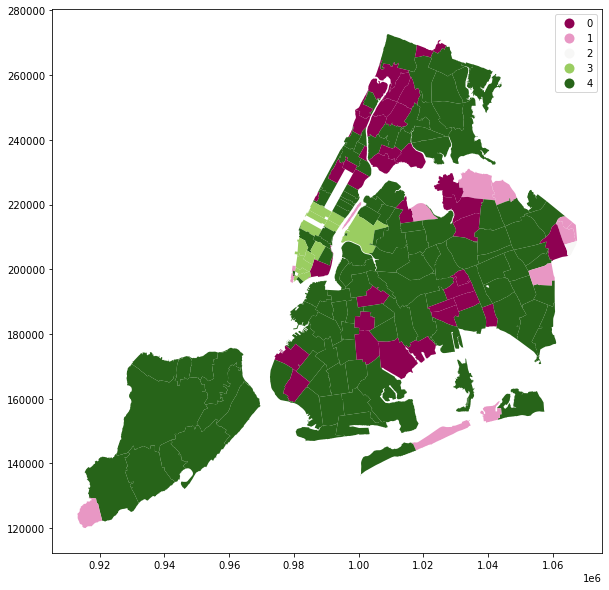

In [46]:
## plot all clustered zips in the map
fig, ax = plt.subplots(1, figsize=(10,10))

selected_df.plot(ax=ax, column='label', legend=True, cmap='PiYG')


### Perform a regression analyses with normalized 311 complaints as the target and above features (normalized number of violations, average score, and ratios of 'A', 'B' and 'C' grades) as regressors. Comment on the signficance of each feature.

Include the intercept for the regression analysis. Try performing regression with each of the regressors individually (with normalized 311 complaints as target). Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.

In [47]:
regress_df = merge_all_df[['ZIPCODE','normalized_complaints','normalized_violations','avg_score','A','B','C']]

In [48]:
regress_df.head()

,ZIPCODE,normalized_complaints,normalized_violations,avg_score,A,B,C
0,10001.0,14.768215,48.498639,19.870285,0.435143,0.066237,0.016559
1,10002.0,4.280180,18.596642,21.900662,0.341270,0.095238,0.029101
2,10003.0,9.037546,29.528616,19.778047,0.391515,0.089091,0.024242
4,10005.0,6.784261,14.061922,18.535088,0.500000,0.052632,0.026316
5,10006.0,12.288276,32.215211,20.247423,0.381443,0.051546,0.041237


In [49]:
# Target - normalized_complaints and Regressor -  normalized_violations

lm_vio = smf.ols(formula = 'normalized_complaints ~ normalized_violations', data = regress_df).fit()
print(lm_vio.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.876
Model:                               OLS   Adj. R-squared:                  0.875
Method:                    Least Squares   F-statistic:                     1259.
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):           1.18e-82
Time:                           14:27:16   Log-Likelihood:                -266.79
No. Observations:                    180   AIC:                             537.6
Df Residuals:                        178   BIC:                             544.0
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [50]:
# Target - normalized_complaints and Regressor -  avg_score

lm_score = smf.ols(formula = 'normalized_complaints ~ avg_score', data = regress_df).fit()
print(lm_score.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.004
Method:                    Least Squares   F-statistic:                    0.2496
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):              0.618
Time:                           14:27:25   Log-Likelihood:                -454.65
No. Observations:                    180   AIC:                             913.3
Df Residuals:                        178   BIC:                             919.7
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2592 

In [51]:
# Target - normalized_complaints and Regressor -  A Grade

lm_A = smf.ols(formula = 'normalized_complaints ~ A', data = regress_df).fit()
print(lm_A.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                 -0.005
Method:                    Least Squares   F-statistic:                    0.1665
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):              0.684
Time:                           14:27:46   Log-Likelihood:                -454.69
No. Observations:                    180   AIC:                             913.4
Df Residuals:                        178   BIC:                             919.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7082 

In [52]:
# Target - normalized_complaints and Regressor -  B Grade

lm_B = smf.ols(formula = 'normalized_complaints ~ B', data = regress_df).fit()
print(lm_B.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.007
Model:                               OLS   Adj. R-squared:                  0.002
Method:                    Least Squares   F-statistic:                     1.285
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):              0.258
Time:                           14:27:57   Log-Likelihood:                -454.12
No. Observations:                    180   AIC:                             912.2
Df Residuals:                        178   BIC:                             918.6
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.5033 

In [53]:
# Target - normalized_complaints and Regressor -  C Grade

lm_C = smf.ols(formula = 'normalized_complaints ~ C', data = regress_df).fit()
print(lm_C.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.006
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.033
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):              0.311
Time:                           14:28:07   Log-Likelihood:                -454.25
No. Observations:                    180   AIC:                             912.5
Df Residuals:                        178   BIC:                             918.9
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.3156 

***Comment on how these regressor perform against each other. What do you think could be any problems when doing regression with all regressors together? Also comment on the coeffiecients of each regressor and whether or not they are significant.***

***Ans***

***Normalized_Violations -*** R-squared: 0.876 , P- value : 0.000 <br>
***Avg Score -*** R-squared: 0.001 , P- value : 0.618 <br>
***A -*** R-squared: 0.001 , P- value : 0.684 <br>
***B -*** R-squared: 0.007 , P- value : 0.258 <br>
***C -*** R-squared: 0.006 , P- value : 0.311 <br>

P-value less than 0.05 is considered as significant, because it shows the 95% significance in results. Only "Normalized Violation" feature has a P value < 0.05, all other features have p-value greater than 0.05. 
Also R2 value is significant for "Normalized violations" feature only, corresponding to rest of the four features its negligible. 

From above analysis, we can say that only "Normalised_Violations" feature is a significant regressor for the model, rest 4 are not performing well hence can cause noise if included while training a model with all regressors together.

In [55]:
#all five features together as regressors with target Normalized complaints
lm_C = smf.ols(formula = 'normalized_complaints ~ normalized_violations+avg_score+A+B+C', data = regress_df).fit()
print(lm_C.summary())

                              OLS Regression Results                             
Dep. Variable:     normalized_complaints   R-squared:                       0.886
Model:                               OLS   Adj. R-squared:                  0.883
Method:                    Least Squares   F-statistic:                     270.7
Date:                   Fri, 10 Dec 2021   Prob (F-statistic):           4.39e-80
Time:                           14:29:35   Log-Likelihood:                -259.27
No. Observations:                    180   AIC:                             530.5
Df Residuals:                        174   BIC:                             549.7
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


When all the regressors are run in one model with target Normalized Complaints, then Normalized violations and A become significant with p value less than 0.05 and all other three still remain insignificant due to high p-value. 

R2 value for model is 0.886

***Coefficient values -***  <br>
normalized_violations =    0.3109     <br> 
avg_score              =   0.0405      <br> 
A                       =  4.3236      <br> 
B                        = 1.8216     <br> 
C                       = -0.1480 <br> 


